# basic API

In [2]:
import requests
import base64
from io import BytesIO
from PIL import Image

URL_API = "http://localhost:5000"

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [3]:
#image_path = "image/coconut.jpg"
image_path = "image/fake.jpg"

Classify the input image

In [40]:
url = URL_API + "/classify"

encoded_image = encode_image_to_base64(image_path)
payload = {"image": encoded_image}
response = requests.post(url, json=payload)
response.text

'not a fruit or vegetable'

Transform the image using the pipeline

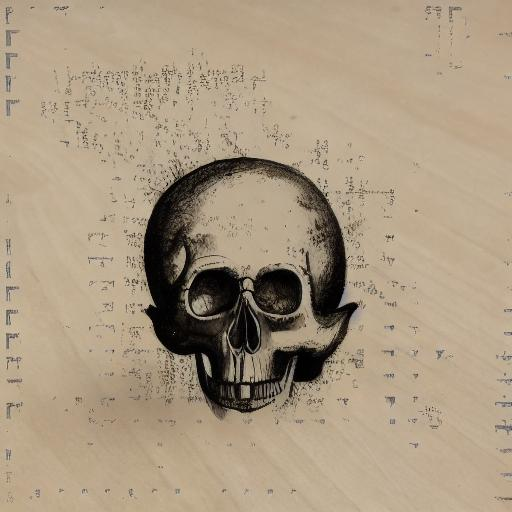

In [41]:
prompt = "A photo of a skull"

url = URL_API + "/transform"

encoded_image = encode_image_to_base64(image_path)
payload = {"image": encoded_image,
          "prompt": prompt}

response = requests.post(url, json=payload)

base64_image = response.text.replace("data:image/jpeg;base64,", "")
image_file = BytesIO(base64.b64decode(base64_image))

image = Image.open(image_file)

image

In [32]:
url = URL_API + "/locate_ip"

encoded_image = encode_image_to_base64(image_path)
payload = {"ip": "8.8.8.8"} # google DNS server

response = requests.post(url, json=payload)

response.json()

{'as': 'AS15169 Google LLC',
 'city': 'Ashburn',
 'country': 'United States',
 'countryCode': 'US',
 'isp': 'Google LLC',
 'lat': 39.03,
 'lon': -77.5,
 'org': 'Google Public DNS',
 'query': '8.8.8.8',
 'region': 'VA',
 'regionName': 'Virginia',
 'status': 'success',
 'timezone': 'America/New_York',
 'zip': '20149'}

In [16]:
ip = "8.8.8.8"
url = f'http://ip-api.com/json/{ip}'
response = requests.get(url)
response.raise_for_status()  # Raises an error for bad responses
response.json()  # Converts the JSON response to a Python dictionary

{'status': 'success',
 'country': 'United States',
 'countryCode': 'US',
 'region': 'VA',
 'regionName': 'Virginia',
 'city': 'Ashburn',
 'zip': '20149',
 'lat': 39.03,
 'lon': -77.5,
 'timezone': 'America/New_York',
 'isp': 'Google LLC',
 'org': 'Google Public DNS',
 'as': 'AS15169 Google LLC',
 'query': '8.8.8.8'}

# ComfyUI

In [8]:
import json

workflow = "default"

def load_workflow(workflow):    
    try:
        with open(f"workflows/{workflow}.json") as f:
            return json.load(f)
    except FileNotFoundError:
        return None

In [9]:
import json
from urllib import request, parse
import random

def queue_prompt(prompt):
    p = {"prompt": prompt}
    data = json.dumps(p).encode('utf-8')
    req =  request.Request("http://127.0.0.1:8188/prompt", data=data)
    request.urlopen(req)

prompt = load_workflow("default")

print(prompt)

queue_prompt(prompt)

{'3': {'inputs': {'seed': 199580836723181, 'steps': 20, 'cfg': 17, 'sampler_name': 'euler', 'scheduler': 'normal', 'denoise': 1, 'model': ['4', 0], 'positive': ['6', 0], 'negative': ['7', 0], 'latent_image': ['5', 0]}, 'class_type': 'KSampler', '_meta': {'title': 'KSampler'}}, '4': {'inputs': {'ckpt_name': 'sd_xl_base_1.0.safetensors'}, 'class_type': 'CheckpointLoaderSimple', '_meta': {'title': 'Load Checkpoint'}}, '5': {'inputs': {'width': 512, 'height': 512, 'batch_size': 1}, 'class_type': 'EmptyLatentImage', '_meta': {'title': 'Empty Latent Image'}}, '6': {'inputs': {'text': 'Realistic renaissance-style portrait of an astronaut in space, detailed starry background, reflective helmet.', 'clip': ['4', 1]}, 'class_type': 'CLIPTextEncode', '_meta': {'title': 'CLIP Text Encode (Prompt)'}}, '7': {'inputs': {'text': 'text, watermark', 'clip': ['4', 1]}, 'class_type': 'CLIPTextEncode', '_meta': {'title': 'CLIP Text Encode (Prompt)'}}, '8': {'inputs': {'samples': ['3', 0], 'vae': ['4', 2]}, 

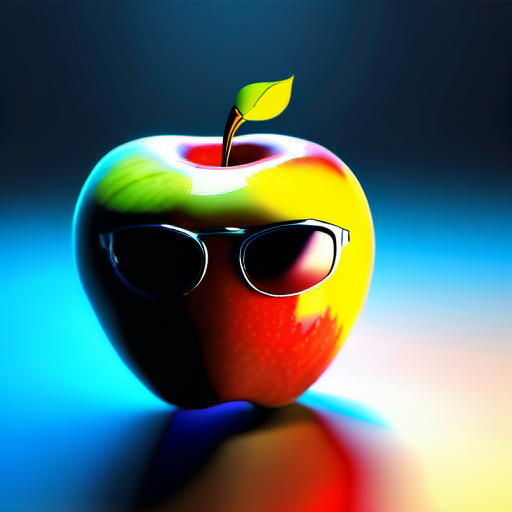

In [63]:
#This is an example that uses the websockets api to know when a prompt execution is done
#Once the prompt execution is done it downloads the images using the /history endpoint

from PIL import Image
import io

import websocket #NOTE: websocket-client (https://github.com/websocket-client/websocket-client)
import uuid
import json
import urllib.request
import urllib.parse

server_address = "127.0.0.1:8188"
client_id = str(uuid.uuid4())

def queue_prompt(prompt):
    p = {"prompt": prompt, "client_id": client_id}
    data = json.dumps(p).encode('utf-8')
    req =  urllib.request.Request("http://{}/prompt".format(server_address), data=data)
    return json.loads(urllib.request.urlopen(req).read())

def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data)
    with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
        return response.read()

def get_history(prompt_id):
    with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
        return json.loads(response.read())

def get_images(ws, prompt):
    prompt_id = queue_prompt(prompt)['prompt_id']
    output_images = {}
    while True:
        out = ws.recv()
        if isinstance(out, str):
            message = json.loads(out)
            if message['type'] == 'executing':
                data = message['data']
                if data['node'] is None and data['prompt_id'] == prompt_id:
                    break #Execution is done
        else:
            continue #previews are binary data

    history = get_history(prompt_id)[prompt_id]
    for o in history['outputs']:
        for node_id in history['outputs']:
            node_output = history['outputs'][node_id]
            if 'images' in node_output:
                images_output = []
                for image in node_output['images']:
                    image_data = get_image(image['filename'], image['subfolder'], image['type'])
                    images_output.append(image_data)
            output_images[node_id] = images_output

    return output_images



prompt = load_workflow("default")
prompt["6"]["inputs"]["text"] = "An apple with sunglasses. stock photo 4k realistic studio lightning"
prompt["3"]["inputs"]["seed"] = 500

ws = websocket.WebSocket()
ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
images = get_images(ws, prompt)

#Commented out code to display the output images:

for node_id in images:
    for image_data in images[node_id]:
        image = Image.open(io.BytesIO(image_data))
        image.show()

In [12]:
images.values()[-1]

dict_keys(['9'])